# Functional API model : Multiple path Personalised Architecture

### Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import concatenate, Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.models import Sequential

### Instanciate GPU

In [2]:
#use gpu
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available:  1


### Process data

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('original data type : ', X_train.dtype)
print('original data range [', np.min(X_train), ',', np.max(X_train),']')

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print('\nconverted data type : ', X_train.dtype)
print('converted data range [', np.min(X_train), ',', np.max(X_train),']')

print('\ntraining data shape : ', X_train.shape)
print('testing data shape  : ', X_test.shape)

original data type :  uint8
original data range [ 0 , 255 ]

converted data type :  float32
converted data range [ 0.0 , 1.0 ]

training data shape :  (50000, 32, 32, 3)
testing data shape  :  (10000, 32, 32, 3)


In [4]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


### Create model

In [5]:
input_shape = X_train.shape[1:]

inputs = Input(shape=input_shape)

# Path 1: Convolution with a small kernel
path_1 = Conv2D(64, (1, 1), padding='same', activation='relu')(inputs)
path_1 = BatchNormalization()(path_1)
path_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(path_1)
path_1 = BatchNormalization()(path_1)

# Path 2: Convolution with a medium kernel
path_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
path_2 = BatchNormalization()(path_2)
path_2 = Conv2D(64, (5, 5), padding='same', activation='relu')(path_2)
path_2 = BatchNormalization()(path_2)

# Path 3: Max Pooling followed by Convolution
path_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
path_3 = Conv2D(64, (1, 1), padding='same', activation='relu')(path_3)
path_3 = BatchNormalization()(path_3)

# Concatenate all paths
concatenated = concatenate([path_1, path_2, path_3], axis=-1)

flatten = Flatten()(concatenated)
dense = Dense(256, activation='relu')(flatten)
dropout = Dropout(0.5)(dense)
outputs = Dense(n_classes, activation='softmax')(dropout)

model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   256         ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

### Train model

In [6]:
E = 10                # number of epochs
B = 64                # batch side
V = 0.2               # validation split

checkpoint_callback = ModelCheckpoint(
    'best_model_d.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

log = model.fit(X_train, Y_train, batch_size=B, epochs=E,
               verbose=1, validation_data=(X_test, Y_test),callbacks=[checkpoint_callback])

Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 3.7274 - accuracy: 0.1045
Epoch 1: val_accuracy improved from -inf to 0.09870, saving model to best_model_d.h5
782/782 [==============================] - 39s 45ms/step - loss: 3.7274 - accuracy: 0.1045 - val_loss: 2.3110 - val_accuracy: 0.0987
Epoch 2/10
781/782 [============================>.] - ETA: 0s - loss: 2.3032 - accuracy: 0.0981
Epoch 2: val_accuracy improved from 0.09870 to 0.09980, saving model to best_model_d.h5
782/782 [==============================] - 36s 46ms/step - loss: 2.3032 - accuracy: 0.0981 - val_loss: 2.3066 - val_accuracy: 0.0998
Epoch 3/10
781/782 [============================>.] - ETA: 0s - loss: 2.3101 - accuracy: 0.0988
Epoch 3: val_accuracy improved from 0.09980 to 0.10000, saving model to best_model_d.h5
782/782 [==============================] - 35s 45ms/step - loss: 2.3101 - accuracy: 0.0988 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/10
781/782 [============================>.] 

### Evaluate model

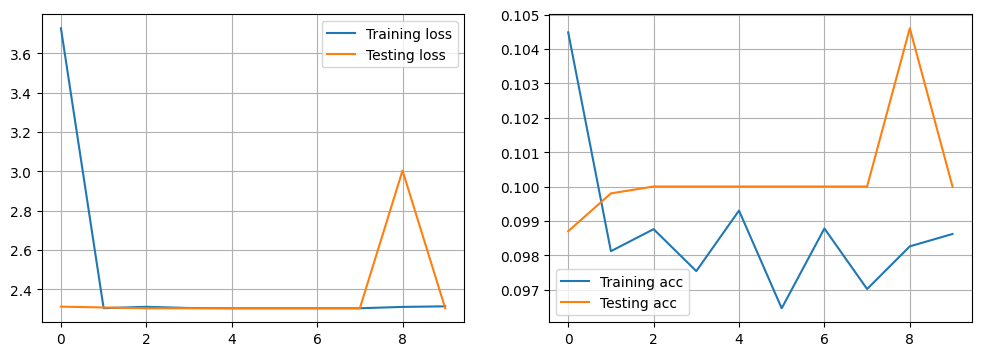

In [7]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [8]:
train_acc = log.history["accuracy"]
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print(f'Train accuracy : {train_acc[-1]}')
print('Test accuracy:', metric_test)

Train accuracy : 0.09861999750137329
Test accuracy: 0.10000000149011612
